#**Import Packages**

In [1]:
# !pip install bitsandbytes --upgrade
# !pip install transformers accelerate --upgrade
# !pip install git+https://github.com/huggingface/peft.git -q
# !pip install torch

import requests
import json
# !pip install jsonlines
import jsonlines
from io import StringIO
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# !pip install datasets
from datasets import load_dataset, Dataset
import torch
import transformers
from transformers import T5Tokenizer, TFT5ForConditionalGeneration
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import pipeline
# !pip install rouge_score
from rouge_score import rouge_scorer

C:\Users\Zane\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [3]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("CUDA is not available. Using CPU.")

PyTorch version: 2.4.0+cu124
CUDA available: True
CUDA version: 12.4
CUDA device count: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce RTX 4070 SUPER


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


#**Load** **Dataset**

In [5]:
print(os.getcwd())

c:\Users\Zane\Downloads


In [6]:
# Function to load the JSON files into a dataframe
def json_to_dataframe(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            try:
                json_obj = json.loads(line.strip())
                flattened = {
                    'id': json_obj['info'].get('id', ''),
                    'post': json_obj['info'].get('post', ''),
                    'title': json_obj['info'].get('title', ''),
                    'subreddit': json_obj['info'].get('subreddit', ''),
                    'split': json_obj.get('split', ''),
                    'summary_text': json_obj['summary'].get('text', ''),
                    'summary_policy': json_obj['summary'].get('policy', ''),
                    'summary_note': json_obj['summary'].get('note', ''),
                    'overall_score': json_obj['summary']['axes'].get('overall', ''),
                    'accuracy_score': json_obj['summary']['axes'].get('accuracy', ''),
                    'coverage_score': json_obj['summary']['axes'].get('coverage', ''),
                    'coherence_score': json_obj['summary']['axes'].get('coherence', ''),
                    'worker': json_obj.get('worker', ''),
                    'batch': json_obj.get('batch', '')
                }
                data.append(flattened)
            except json.JSONDecodeError:
                print(f"Skipping invalid JSON: {line}")
            except KeyError as e:
                print(f"Missing key in JSON object: {e}")

    df = pd.DataFrame(data)
    return df

Load the summarization data

In [6]:
import requests
def get_data(subreddit):
  response = requests.get(subreddit)
  response.raise_for_status()
  data = []
  for line in response.iter_lines():
    if line:
      data.append(json.loads(line))
  return data

train_url = "https://openaipublic.blob.core.windows.net/summarize-from-feedback/datasets/tldr_3_filtered/train.jsonl"
test_url = "https://openaipublic.blob.core.windows.net/summarize-from-feedback/datasets/tldr_3_filtered/test.jsonl"
val_url = "https://openaipublic.blob.core.windows.net/summarize-from-feedback/datasets/tldr_3_filtered/valid.jsonl"

In [7]:
train_data = get_data(train_url)
test_data = get_data(test_url)
val_data = get_data(val_url)

Load the human preference data

In [9]:
# tldraxis1
tldraxis1 = json_to_dataframe('./tldraxis1.json')

# tldraxis2
tldraxis2 = json_to_dataframe('./tldraxis2.json')

# cnndm1
cnndm1 = json_to_dataframe('./cnndm1.json')

# cnndm3
cnndm3 = json_to_dataframe('./cnndm3.json')

# cnndm4
cnndm4 = json_to_dataframe('./cnndm4.json')

# cnndm0
cnndm0 = json_to_dataframe('./cnndm0.json')

# cnndm2
cnndm2 = json_to_dataframe('./cnndm2.json')

# batch0_cnndm
batch0_cnndm = json_to_dataframe('./batch0_cnndm.json')

Missing key in JSON object: 'summary'
Missing key in JSON object: 'summary'
Missing key in JSON object: 'summary'
Missing key in JSON object: 'summary'
Missing key in JSON object: 'summary'
Missing key in JSON object: 'summary'
Missing key in JSON object: 'summary'
Missing key in JSON object: 'summary'
Missing key in JSON object: 'summary'
Missing key in JSON object: 'summary'
Missing key in JSON object: 'summary'
Missing key in JSON object: 'summary'
Missing key in JSON object: 'summary'
Missing key in JSON object: 'summary'
Missing key in JSON object: 'summary'
Missing key in JSON object: 'summary'
Missing key in JSON object: 'summary'
Missing key in JSON object: 'summary'
Missing key in JSON object: 'summary'
Missing key in JSON object: 'summary'
Missing key in JSON object: 'summary'
Missing key in JSON object: 'summary'
Missing key in JSON object: 'summary'
Missing key in JSON object: 'summary'
Missing key in JSON object: 'summary'
Missing key in JSON object: 'summary'
Missing key 

# **EDA and Pre-processing**

In [10]:
tldraxis1.describe()

,id,post,title,subreddit,split,summary_text,summary_policy,summary_note,overall_score,accuracy_score,coverage_score,coherence_score,worker,batch
count,3056,3056,3056,3056,3056,3056,3056,3052,3056,3056,3056,3056,3056,3056
unique,441,441,441,25,2,2642,6,2838,15,15,15,15,17,1
top,t3_2k0qfz,I was fired last week from my seasonal part-ti...,TIFU by getting fired at the most unfortunate ...,relationships,valid2,I was fired at the worst possible time and ma...,sup4_ppo_rm4_t.7,Looks good to me.,4,7,4,7,OKFDIsAZl6Qa0m9x26f5Ao4S0uc7Ca,tldraxis1
freq,36,36,36,1662,2211,6,510,50,555,1146,703,1429,480,3056


In [11]:
cnndm1.head(4)

,id,post,title,subreddit,split,summary_text,summary_policy,summary_note,overall_score,accuracy_score,coverage_score,coherence_score,worker,batch
0,167f80cc6634b166a699d182e25c81a2349d82d2,,Newcastle United midfielder Moussa Sissoko fac...,,test,Moussa Sissoko was sent off against Liverpool ...,ref,"Misleading: ""Carver admits he is only concerne...",3,5,4,2,qo6WIyEh27cwAjWpA3Q60J7NaDxzQJ,cnndm1
1,167f80cc6634b166a699d182e25c81a2349d82d2,,Newcastle United midfielder Moussa Sissoko fac...,,test,Newcastle have a mountain to climb in the Prem...,sup4_t0.7,"""Carver is determined to make the most of his ...",1,3,1,1,qo6WIyEh27cwAjWpA3Q60J7NaDxzQJ,cnndm1
2,167f80cc6634b166a699d182e25c81a2349d82d2,,Newcastle United midfielder Moussa Sissoko fac...,,test,Moussa Sissoko has been sent off following a d...,sup4_ppo_rm4_t.7,"""Carver feels the player should have been sent...",2,4,2,2,qo6WIyEh27cwAjWpA3Q60J7NaDxzQJ,cnndm1
3,167f80cc6634b166a699d182e25c81a2349d82d2,,Newcastle United midfielder Moussa Sissoko fac...,,test,Moussa Sissoko is facing a disciplinary action...,pretrain_xl_t.7,Doesnt summarize important points. Match info ...,3,7,3,6,qo6WIyEh27cwAjWpA3Q60J7NaDxzQJ,cnndm1


In [12]:
cnndm3['split'].value_counts()

split
test    969
Name: count, dtype: int64

In [13]:
tldraxis1['split'].value_counts()

split
valid2    2211
valid1     845
Name: count, dtype: int64

In [14]:
tldraxis1.isnull().sum()

id                 0
post               0
title              0
subreddit          0
split              0
summary_text       0
summary_policy     0
summary_note       4
overall_score      0
accuracy_score     0
coverage_score     0
coherence_score    0
worker             0
batch              0
dtype: int64

In [15]:
tldraxis2.isnull().sum()

id                 0
post               0
title              0
subreddit          0
split              0
summary_text       0
summary_policy     0
summary_note       1
overall_score      0
accuracy_score     0
coverage_score     0
coherence_score    0
worker             0
batch              0
dtype: int64

In [16]:
cnndm1.isnull().sum()

id                 0
post               0
title              0
subreddit          0
split              0
summary_text       0
summary_policy     0
summary_note       3
overall_score      0
accuracy_score     0
coverage_score     0
coherence_score    0
worker             0
batch              0
dtype: int64

In [17]:
cnndm3.isnull().sum()

id                 0
post               0
title              0
subreddit          0
split              0
summary_text       0
summary_policy     0
summary_note       1
overall_score      0
accuracy_score     0
coverage_score     0
coherence_score    0
worker             0
batch              0
dtype: int64

### There are some null values in the summary_note column for each dataframe. The summary note will not be used in our model training - it is a reference column for the human preference interpreter.

In [18]:
print("Train data", train_data[0])
print("Test data", test_data[0])
print("Validation data", val_data[0])

Train data {'id': 't3_1hxu8s', 'subreddit': 'relationships', 'title': 'I (f/22) have to figure out if I want to still know these girls or not and would hate to sound insulting', 'post': "Not sure if this belongs here but it's worth a try. \n\nBackstory:\nWhen I (f/22) went through my first real breakup 2 years ago because he needed space after a year of dating roand  it effected me more than I thought. It was a horrible time in my life due to living with my mother and finally having the chance to cut her out of my life. I can admit because of it was an emotional wreck and this guy was stable and didn't know how to deal with me. We ended by him avoiding for a month or so after going to a festival with my friends. When I think back I wish he just ended. So after he ended it added my depression I suffered but my friends helped me through it and I got rid of everything from him along with cutting contact. \n\nNow: Its been almost 3 years now and I've gotten better after counselling and mil

In [8]:
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)
val_df = pd.DataFrame(val_data)

In [9]:
train_df.head()

,id,subreddit,title,post,summary
0,t3_1hxu8s,relationships,I (f/22) have to figure out if I want to still...,Not sure if this belongs here but it's worth a...,I still have contact with an old ex's friends ...
1,t3_33lz18,loseit,SV & NSV! Keeping on keeping on.,"30F, 5'6"". SW: 236 GW: 150 CW: 219\n\nI weigh ...","Progress is still happening, even when you thi..."
2,t3_38a85h,relationships,"Me [19F] with my friend [19M] 10 months, Insec...",What are your stories about insecurities you'v...,My skin is scarred badly; what could I do/say ...
3,t3_2as12n,personalfinance,Prioritize student debt or saving for down pay...,I have $25k in student debt. One private loan ...,$14k in student debt (all <5%) and need to sav...
4,t3_2bzi1g,relationships,My[25m] girlfriend [24f] is only nice and plea...,Throwaway\n\nI noticed the more I'm cold and d...,"GF is a meanie-bo-beanie when I'm nice, and an..."


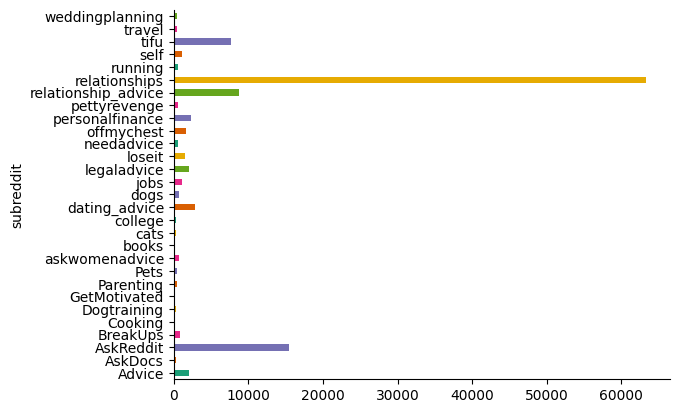

In [27]:
train_df.groupby('subreddit').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### There are many more data points for the 'relationships' subreddit. To help with compute and better normalize our distribution, we'll remove 70% of these examples. We'll leave our val and test set as-is. This will likely lead to higher loss but worth it for compute.

In [10]:
subreddit_counts = train_df['subreddit'].value_counts()
relationship_count = subreddit_counts['relationships']
print(f"Number of 'relationships' examples: {relationship_count}")

Number of 'relationships' examples: 63324


In [11]:
keep_ratio = 0.3
keep_count = int(relationship_count * keep_ratio)

# Create a boolean mask for the rows to keep
mask = ~((train_df['subreddit'] == 'relationships') & (train_df.index >= keep_count))

# Apply the mask to create a new DataFrame
df_train_balanced = train_df[mask].reset_index(drop=True)

# Check the new distribution
new_subreddit_counts = df_train_balanced['subreddit'].value_counts()
print(new_subreddit_counts)

subreddit
AskReddit              15440
relationships          10377
relationship_advice     8691
tifu                    7685
dating_advice           2849
personalfinance         2312
Advice                  2088
legaladvice             1997
offmychest              1582
loseit                  1452
jobs                    1084
self                    1048
BreakUps                 838
askwomenadvice           688
dogs                     638
running                  567
pettyrevenge             548
needadvice               528
travel                   452
Parenting                435
weddingplanning          433
Pets                     366
Dogtraining              362
cats                     324
AskDocs                  283
college                  264
GetMotivated             169
books                    161
Cooking                  114
Name: count, dtype: int64


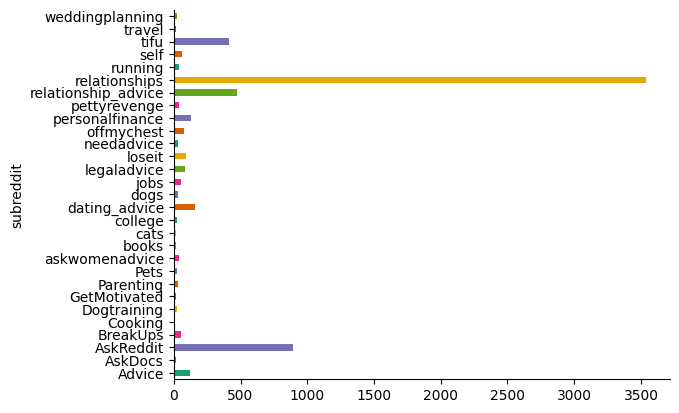

In [ ]:
test_df.groupby('subreddit').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# **Pre-Trained Models**

### **Llama-2-7b**

### **BART**

In [12]:
# Convert DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(df_train_balanced)
eval_dataset = Dataset.from_pandas(val_df)

In [31]:
torch.cuda.is_available()

True

In [99]:
import pandas as pd
import torch
# !pip install bitsandbytes as bnb
# !pip install transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer, BitsAndBytesConfig
from datasets import Dataset
# !pip install peft
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from torch.utils.data import DataLoader

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_storage=torch.bfloat16,
)

# Load tokenizer
bart_tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')

# Load model with quantization config
bart_model = AutoModelForSeq2SeqLM.from_pretrained('facebook/bart-large',
                                              quantization_config=bnb_config,
                                              torch_dtype=torch.bfloat16,
                                              device_map="auto" if device == torch.device("cuda") else None)

# Prepare the model for k-bit training
bart_model = prepare_model_for_kbit_training(bart_model)

# Define LoRA Config
peft_config = LoraConfig(
    task_type="SEQ_2_SEQ_LM",
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj"],

    # Implement DoRA
    use_dora=True
)

# Get the PEFT model
bart_model = get_peft_model(bart_model, peft_config)

bart_model = bart_model.to(device)

# Enable gradient checkpointing
bart_model.gradient_checkpointing_enable()

# Check that model parameters require gradients
for param in bart_model.parameters():
    if param.dtype in [torch.float16, torch.float32, torch.float64, torch.complex64, torch.complex128]:
        param.requires_grad = True

In [100]:
# Tokenize the data
def preprocess_function(examples):
    inputs = bart_tokenizer(examples['post'], max_length=512, truncation=True, padding="max_length", return_tensors="pt")
    targets = bart_tokenizer(examples['summary'], max_length=128, truncation=True, padding="max_length", return_tensors="pt")
    return {"input_ids": inputs["input_ids"], "attention_mask": inputs["attention_mask"], "labels": targets["input_ids"]}

tokenized_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=['id', 'subreddit', 'title'])

# Preprocess the evaluation dataset
tokenized_eval_dataset = eval_dataset.map(preprocess_function, batched=True, remove_columns=['id', 'subreddit', 'title'])

Map: 100%|██████████| 6447/6447 [00:01<00:00, 3814.74 examples/s]


In [101]:
import torch

def print_gpu_memory():
    if torch.cuda.is_available():
        print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
        print(f"GPU memory cached: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

# Call this function at key points in your training loop
print_gpu_memory()

GPU memory allocated: 3969.96 MB
GPU memory cached: 6790.00 MB


In [102]:
bart_model.print_trainable_parameters()

trainable params: 55,223,296 || all params: 407,544,832 || trainable%: 13.5502


In [103]:
device

device(type='cuda')

In [104]:
data_collator = DataCollatorForSeq2Seq(bart_tokenizer, model=bart_model)

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    eval_steps=100,  # Evaluate every 100 steps
    learning_rate=1e-3,
    per_device_train_batch_size=48,
    per_device_eval_batch_size=48,
    num_train_epochs=2,
    weight_decay=0.01,
    push_to_hub=False,
    logging_dir='./logs',
    logging_steps=100,
    bf16=True,
    metric_for_best_model="eval_loss",  # Use eval_loss to determine the best model
    greater_is_better=False,  # Lower loss is better
    gradient_accumulation_steps=4,  # Added gradient accumulation
    warmup_ratio=0.1,  # Added warmup
    lr_scheduler_type="linear"  # Added linear learning rate decay
)

# Define the trainer
trainer = Seq2SeqTrainer(
    model=bart_model,
    args=training_args,
    train_dataset=tokenized_dataset,
    eval_dataset=tokenized_eval_dataset,
    data_collator=data_collator,
    tokenizer=bart_tokenizer,
)

# Train the model
trainer.train()

 15%|█▌        | 100/664 [17:14<1:37:07, 10.33s/it]

{'loss': 3.6, 'grad_norm': 0.22765450179576874, 'learning_rate': 0.0009447236180904523, 'epoch': 0.3}


 30%|███       | 200/664 [34:22<1:18:52, 10.20s/it]

{'loss': 0.64, 'grad_norm': 0.23279891908168793, 'learning_rate': 0.0007772194304857622, 'epoch': 0.6}


 45%|████▌     | 300/664 [51:41<1:03:43, 10.50s/it]

{'loss': 0.64, 'grad_norm': 0.20687654614448547, 'learning_rate': 0.0006097152428810721, 'epoch': 0.9}


 50%|█████     | 332/664 [58:54<57:20, 10.36s/it]

{'eval_loss': 0.6263094544410706, 'eval_runtime': 96.5383, 'eval_samples_per_second': 66.782, 'eval_steps_per_second': 1.398, 'epoch': 1.0}


 60%|██████    | 400/664 [1:10:43<45:49, 10.41s/it]  

{'loss': 0.64, 'grad_norm': 0.19651158154010773, 'learning_rate': 0.00044221105527638197, 'epoch': 1.2}


 75%|███████▌  | 500/664 [1:27:49<28:03, 10.27s/it]

{'loss': 0.64, 'grad_norm': 0.1904231160879135, 'learning_rate': 0.00027470686767169176, 'epoch': 1.5}


C:\Users\Zane\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
 90%|█████████ | 600/664 [1:45:09<10:56, 10.25s/it]

{'loss': 0.64, 'grad_norm': 0.1722136288881302, 'learning_rate': 0.00010720268006700168, 'epoch': 1.81}


100%|██████████| 664/664 [1:57:38<00:00, 10.63s/it]

{'eval_loss': 0.6198016405105591, 'eval_runtime': 94.8924, 'eval_samples_per_second': 67.94, 'eval_steps_per_second': 1.423, 'epoch': 2.0}
{'train_runtime': 7058.7308, 'train_samples_per_second': 18.07, 'train_steps_per_second': 0.094, 'train_loss': 1.0835843373493976, 'epoch': 2.0}


TrainOutput(global_step=664, training_loss=1.0835843373493976, metrics={'train_runtime': 7058.7308, 'train_samples_per_second': 18.07, 'train_steps_per_second': 0.094, 'total_flos': 1.3861230601882829e+17, 'train_loss': 1.0835843373493976, 'epoch': 1.99849510910459})

In [13]:
# Save the model
output_dir = "./BART_QDoRA_summarization_model"
trainer.save_model(output_dir)

# Save the tokenizer
bart_tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")

NameError: name 'trainer' is not defined

In [14]:
# Save some memory.

# del bart_model
# del bart_tokenizer
torch.cuda.empty_cache()

## QDoRA BART Evaluation

In [15]:
test_df

,id,subreddit,title,post,summary
0,t3_1wbdsh,relationships,"Me [19 F] with my friend [19 M], not sure if I...",Hello hello everybody. I hope this isn't too t...,"I really like this guy, but after having sex w..."
1,t3_4sdnjx,Parenting,"My 11 year old sons friend died suddenly, his ...",**repost from relationships**\n\nA couple of w...,Sons good friend died and his funeral is today...
2,t3_2g42p8,relationships,The girl [26 F] I [22 M] have been seeing for ...,"She gets terrible service while at her house, ...",Girl I'm seeing didn't respond to my texts whi...
3,t3_4oyv23,tifu,TIFU by accidently kicking an old woman,So this didn't happen today but actually about...,"Tried to stop an old lady falling, kicked her ..."
4,t3_2u6e8x,relationships,I [32 M] found out my wife [31 F] had an affai...,Wife and I moved accross the country with our ...,Wife Cheats on me but I stuck around for kids....
...,...,...,...,...,...
6548,t3_1w9swx,relationships,Me [22M] with my significant other [22F] of 7 ...,* I've been a long time user but mainly just l...,"Been in a relationship since high school, now ..."
6549,t3_3pmpp1,loseit,"Metabolism changes, gained weight while I was ...",Hey guys!\nBasically I've always had quite a f...,"was losing weight with a fast metabolism, star..."
6550,t3_35aciq,relationships,My [24F] step-second-cousin (?) [33M] asked me...,This person is my step dad (of 6 months)'s fir...,Second step cousin asked me on a date. What le...
6551,t3_3couur,relationships,"My [30 M] with my wife [30 F] of 6 years, toge...",Ive been together with my wife 11 years and ma...,Wife gets upset if I express any dissatisfacti...


In [17]:
# Load your trained model and tokenizer
model_path = "./BART_QDoRA_summarization_model"
QDoRA_BART_model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
QDoRA_BART_tokenizer = AutoTokenizer.from_pretrained(model_path)

In [22]:
# Move model to GPU if available
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
QDoRA_BART_model = QDoRA_BART_model.to(device)
QDoRA_BART_model.eval()

OptimizedModule(
  (_orig_mod): BartForConditionalGeneration(
    (model): BartModel(
      (shared): Embedding(50265, 1024, padding_idx=1)
      (encoder): BartEncoder(
        (embed_tokens): BartScaledWordEmbedding(50265, 1024, padding_idx=1)
        (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
        (layers): ModuleList(
          (0-11): 12 x BartEncoderLayer(
            (self_attn): BartSdpaAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): lora.Linear(
                (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1024, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=1024, b

In [31]:
import pandas as pd
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import evaluate
import torch
from tqdm import tqdm
import numpy as np
from functools import partial
from multiprocessing import Pool, cpu_count
from rouge import Rouge

# Load ROUGE metric
rouge = Rouge()

def generate_summaries(posts):
    inputs = QDoRA_BART_tokenizer(posts, return_tensors="pt", max_length=512, truncation=True, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        summary_ids = QDoRA_BART_model.generate(
            inputs["input_ids"],
            max_length=150,
            min_length=40,
            length_penalty=2.0,
            num_beams=4,
            early_stopping=True
        )
    return QDoRA_BART_tokenizer.batch_decode(summary_ids, skip_special_tokens=True)

def compute_rouge(reference, prediction):
    return rouge.get_scores(prediction, reference)[0]

class SummarizationDataset(Dataset):
    def __init__(self, dataframe):
        self.posts = dataframe['post'].tolist()
        self.summaries = dataframe['summary'].tolist()

    def __len__(self):
        return len(self.posts)

    def __getitem__(self, idx):
        return self.posts[idx], self.summaries[idx]

# Prepare the dataset and dataloader
dataset = SummarizationDataset(test_df)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

# Process batches
all_metrics = []

for batch_posts, batch_summaries in tqdm(dataloader):
    generated_summaries = generate_summaries(batch_posts)
    
    with Pool(cpu_count()) as p:
        batch_metrics = p.starmap(compute_rouge, zip(batch_summaries, generated_summaries))
    
    all_metrics.extend(batch_metrics)

# Compute average scores
avg_metrics = {key: np.mean([m[key] for m in all_metrics]) for key in all_metrics[0].keys()}

# Print results
print("\nAverage Metrics:")
for metric, score in avg_metrics.items():
    print(f"{metric}: {score:.4f}")

  0%|          | 0/410 [00:00<?, ?it/s]

# **OLD/ARCHIVE/DELETE**

In [ ]:
#Initialize model
from transformers import BartForConditionalGeneration

model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

In [ ]:
from transformers import Trainer, TrainingArguments

rouge_metric = load_metric("rouge")
bleu_metric = load_metric("bleu")

def compute_metrics(eval_pred):
    labels_ids = eval_pred.label_ids
    pred_ids = eval_pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_results = rouge_metric.compute(predictions=pred_str, references=label_str, use_stemmer=True)
    pred_tokens = [pred.split() for pred in pred_str]
    label_tokens = [[label.split()] for label in label_str]

    bleu_results = bleu_metric.compute(predictions=pred_tokens, references=label_tokens)

    rouge_scores = {
        "rouge1": rouge_results["rouge1"].mid.fmeasure,
        "rouge2": rouge_results["rouge2"].mid.fmeasure,
        "rougeL": rouge_results["rougeL"].mid.fmeasure,
        "rougeLsum": rouge_results["rougeLsum"].mid.fmeasure,
    }

    bleu_score = bleu_results["bleu"]

    metrics = {**rouge_scores, "bleu": bleu_score}

    return metrics




training_args = TrainingArguments(
    output_dir = './results',
    num_train_epochs=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    gradient_accumulation_steps=8,
    logging_steps=10,
    save_steps=10,
    fp16 = True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset, # Pass the Dataset object here
    eval_dataset=val_dataset , # Pass the Dataset object here
    compute_metrics=compute_metrics
)

trainer.train()

The repository for rouge contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/rouge.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for bleu contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/bleu.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Step,Training Loss
10,7.579800
20,7.558100
30,7.006600
40,6.692400
50,6.501200
60,6.079300
70,5.924700
80,5.600200
90,5.247400
100,4.774900


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

TrainOutput(global_step=186, training_loss=4.9763036235686275, metrics={'train_runtime': 614.026, 'train_samples_per_second': 4.886, 'train_steps_per_second': 0.303, 'total_flos': 871846918225920.0, 'train_loss': 4.9763036235686275, 'epoch': 2.976})

In [ ]:
#evaluating the model
eval_results = trainer.evaluate(eval_dataset = test_dataset)
print(eval_results)

OutOfMemoryError: CUDA out of memory. Tried to allocate 326.00 MiB. GPU 

In [ ]:
#!pip install datasets
#!pip install --upgrade pyarrow
#!pip install pyarrow==6.0.1

print("Evaluation Results:")
for key, value in eval_results.items():
    print(f"{key}: {value}")


Evaluation Results:
eval_loss: 2.2736010551452637
eval_runtime: 11.829
eval_samples_per_second: 84.538
eval_steps_per_second: 42.269
epoch: 2.976


In [ ]:
#Initialize the Trainer with compute_metrics
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset, # Pass the Dataset object here
    eval_dataset=val_dataset,  # Pass the Dataset object here
    compute_metrics=compute_metrics # Pass the compute_metrics function here
)

trainer.train()



Step,Training Loss
10,2.607400
20,2.631200
30,2.546900
40,2.568200
50,2.482700
60,2.521400
70,2.407800
80,2.355100
90,2.302000
100,2.196200


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

OutOfMemoryError: CUDA out of memory. Tried to allocate 692.00 MiB. GPU 

In [ ]:
##evaluating the model
eval_results = trainer.evaluate(eval_dataset = test_dataset) # Remove compute_metrics from here
print(eval_results)

print("Rouge Scores:")
print(f"Rouge-1: {eval_results['eval_rouge1']}") # Access metrics with 'eval_' prefix
print(f"Rouge-2: {eval_results['eval_rouge2']}")
print(f"Rouge-L: {eval_results['eval_rougeL']}")
print(f"Rouge-Lsum: {eval_results['eval_rougeLsum']}")

print("\nBleu Score:")
print(f"Bleu: {eval_results['eval_bleu']}")


OutOfMemoryError: CUDA out of memory. Tried to allocate 384.00 MiB. GPU 

### **Training BART**

In [ ]:
#Preprocess data

#tokenize data using Bart tokenizer

def tokenize_data(data, tokenizer):
    inputs = data.apply(lambda x: f"{x['title']} {tokenizer.sep_token} {x['post']}", axis=1).tolist() # Convert inputs to a list
    targets = data["summary"].tolist() # Call the tolist function to get a list of targets

    encodings = tokenizer(inputs, truncation=True, padding=True)
    targets = tokenizer(targets, truncation=True, padding=True)

    return encodings, targets

In [ ]:
train_encodings, train_targets = tokenize_data(train_df, tokenizer)
test_encodings, test_targets = tokenize_data(test_df, tokenizer)
val_encodings, val_targets = tokenize_data(val_df, tokenizer)

In [ ]:
#create a pytorch dataset.
#This will convert the tokenized data into format that can be fed into te model

#Initialize model
from transformers import BartForConditionalGeneration, TrainingArguments, Trainer
from torch.utils.data import Dataset

# Wrap tokenized data in a Dataset object
class NewsSummaryDataset(Dataset):
    def __init__(self, encodings, targets):
        self.encodings = encodings
        self.targets = targets

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.targets['input_ids'][idx]  # Add 'labels' key for target data
        return item

    def __len__(self):
        return len(self.encodings.input_ids)

# Create Dataset objects
train_dataset = NewsSummaryDataset(train_encodings, train_targets)
val_dataset = NewsSummaryDataset(val_encodings, val_targets)
test_dataset = NewsSummaryDataset(test_encodings, test_targets)



In [ ]:
# # Convert DataFrame to Hugging Face Dataset
# dataset = Dataset.from_pandas(train_df)

# # Remove Columns
# dataset = dataset.remove_columns(['id', 'subreddit', 'title'])

# # Tokenization function
# def tokenize_function(examples):
#     inputs = tokenizer(examples['post'], truncation=True, max_length=512, padding='max_length')
#     outputs = tokenizer(examples['summary'], truncation=True, max_length=128, padding='max_length')
#     inputs['labels'] = outputs['input_ids']

#     # Replace padding token id's of the labels by -100 so it's ignored by the loss
#     inputs['labels'] = [[-100 if token == tokenizer.pad_token_id else token for token in label] for label in inputs['labels']]

#     return inputs

# # Tokenize the dataset
# tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=dataset.column_names)

# print(tokenized_dataset)

# # Data collator
# data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, pad_to_multiple_of=8)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1000
})


In [ ]:
peft_model.save_pretrained('./fine-tuned-bart')
tokenizer.save_pretrained('./fine-tuned-bart')

### **Evaluating BART**

In [ ]:
#evaluation
def evaluate(model, tokenizer, dataset):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    references = []
    # Iterate over the rows of the DataFrame
    for _, example in dataset.iterrows():
        summary = generate_summary(example['post'][0])
        predictions.append(summary)
        references.append(example['summary'][0])
    return predictions, references

results = evaluate(model, tokenizer, val_df)
print(results)

In [ ]:
#evaluate
from rouge import Rouge
rouge = Rouge()
rouge.get_scores(results[0], results[1])



# **Evaluation**

In [ ]:
from datasets import load_metric

metric = load_metric('rouge')

def evaluate(model, tokenizer, dataset):
    model.eval()
    predictions = []
    references = []
    for example in dataset:
        inputs = tokenizer(example['post'], return_tensors="pt")
        output = model.generate(**inputs)
        prediction = tokenizer.decode(output[0], skip_special_tokens=True)
        predictions.append(prediction)
        references.append(example['summary'])
    results = metric.compute(predictions=predictions, references=references)
    return results

results = evaluate(model, tokenizer, train_df)
print(results)

# **T5**

In [ ]:
from transformers import T5Tokenizer, TFT5ForConditionalGeneration

In [ ]:

t5model = TFT5ForConditionalGeneration.from_pretrained("t5-small")
t5tokenizer = T5Tokenizer.from_pretrained("t5-small")


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

ResourceExhaustedError: {{function_node __wrapped__StatelessTruncatedNormalV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[32128,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessTruncatedNormalV2] name: 

In [ ]:
t5model.summary()

In [ ]:
def tokenize_data(data, tokenizer):
    inputs = data.apply(lambda x: f"{x['title']} {tokenizer.sep_token} {x['post']}", axis=1).tolist() # Convert inputs to a list
    targets = data["summary"].tolist() # Call the tolist function to get a list of targets

    encodings = tokenizer(inputs, truncation=True, padding=True)
    targets = tokenizer(targets, truncation=True, padding=True)

    return encodings, targets

In [ ]:
train_dataset = NewsSummaryDataset(train_encodings, train_targets)
val_dataset = NewsSummaryDataset(val_encodings, val_targets)
test_dataset = NewsSummaryDataset(test_encodings, test_targets)

In [ ]:
class NewsSummaryDataset(Dataset):
    def __init__(self, encodings, targets):
        self.encodings = encodings
        self.targets = targets

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.targets['input_ids'][idx]  # Add 'labels' key for target data
        return item

    def __len__(self):
        return len(self.encodings.input_ids)

# Create Dataset objects
train_dataset = NewsSummaryDataset(train_encodings, train_targets)
val_dataset = NewsSummaryDataset(val_encodings, val_targets)
test_dataset = NewsSummaryDataset(test_encodings, test_targets)


In [ ]:
model = TFT5ForConditionalGeneration.from_pretrained("t5-small")

In [ ]:
from transformers import Trainer, TrainingArguments

rouge_metric = load_metric("rouge")
bleu_metric = load_metric("bleu")

def compute_metrics(eval_pred):
    labels_ids = eval_pred.label_ids
    pred_ids = eval_pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_results = rouge_metric.compute(predictions=pred_str, references=label_str, use_stemmer=True)
    pred_tokens = [pred.split() for pred in pred_str]
    label_tokens = [[label.split()] for label in label_str]

    bleu_results = bleu_metric.compute(predictions=pred_tokens, references=label_tokens)

    rouge_scores = {
        "rouge1": rouge_results["rouge1"].mid.fmeasure,
        "rouge2": rouge_results["rouge2"].mid.fmeasure,
        "rougeL": rouge_results["rougeL"].mid.fmeasure,
        "rougeLsum": rouge_results["rougeLsum"].mid.fmeasure,
    }

    bleu_score = bleu_results["bleu"]

    metrics = {**rouge_scores, "bleu": bleu_score}

    return metrics









training_args = TrainingArguments(
    output_dir = './results',
    num_train_epochs=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    gradient_accumulation_steps=8,
    logging_steps=10,
    save_steps=10,
    fp16 = True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

In [ ]:

eval_results = trainer.evaluate(eval_dataset = test_dataset) # Remove compute_metrics from here
print(eval_results)

print("Rouge Scores:")
print(f"Rouge-1: {eval_results['eval_rouge1']}") # Access metrics with 'eval_' prefix
print(f"Rouge-2: {eval_results['eval_rouge2']}")
print(f"Rouge-L: {eval_results['eval_rougeL']}")
print(f"Rouge-Lsum: {eval_results['eval_rougeLsum']}")

print("\nBleu Score:")
print(f"Bleu: {eval_results['eval_bleu']}")



In [ ]:
#def preprocess(examples):
   # inputs = ["summarize: " + example for example in examples["post"]]
   # targets = [example for example in examples["summary"]]
   # model_inputs = t5tokenizer(inputs, max_length=1024, truncation=True)

    #tokenizer for targets
   # with t5tokenizer.as_target_tokenizer():
    #    labels = t5tokenizer(targets, max_length=150, truncation=True)

    #model_inputs["labels"] = labels["input_ids"]
    #return model_inputs


#PROMT = "summarize: "
#T5POST_TO_SUMMARIZE = PROMT + train_df['post'][0]
#T5POST_TO_SUMMARIZE

# Convert the Pandas Series to a list of strings
#T5POST_TO_SUMMARIZE_LIST = [T5POST_TO_SUMMARIZE] # Wrap the string in a list

# Tokenize the list of strings
#inputs = t5tokenizer(T5POST_TO_SUMMARIZE_LIST, max_length=1024, truncation=True)

#inputs

# Generate Summary
#summary_ids = t5model.generate(inputs["input_ids"],
                               #max_length=150,
                               #num_beams=5,
                               #no_repeat_ngram_size=2,
                               #max_new_tokens = 30,
                               #min_length = 75,
                               #early_stopping=True
#)
#candidate = t5tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
#pprint(candidate[0], compact=True)#

In [ ]:
from pprint import pprint

In [ ]:
#rouge = evaluate.load('rouge')
#ground_truth_summary = train_df['summary'].iloc[0]
#results = rouge.compute(predictions=candidate[0], references=ground_truth_summary)
#pprint(results)

rouge = evaluate.load('rouge')
ground_truth_summary = train_df['summary'].iloc[0]
# Pass a list of predictions and references
results = rouge.compute(predictions=[candidate[0]], references=[ground_truth_summary])
pprint(results)



**GPT 2**

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("summarization", model="openai-community/gpt2")

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")

In [ ]:
def generate_summary(post):
    input_text =
    inputs = tokenizer(post, return_tensors="pt", max_length=1024, truncation=True)

